In [74]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

from scipy.stats import betabinom

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import gc

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import CausalityDataset

from flaml import AutoML
import wise_pizza as wp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Propensity Model Selection for CausalTune 

CausalTune effect estimation consists of multiple models that can / need to be fitted.

1. Propensity model to estimate treatment propensities from features $\mathbb{E}[T|X,W]$.
2. Outcome model to estimate outcomes from features $\mathbb{E}[Y|X,W]$
3. The final causal inference estimator which requires additional hyperparamter tuning.

In this notebook, we focu on the Propensity Model (1.).

There are four options to finding a propensity model.

1. [Default:] Letting AutoML fit the propoensity model,
2. supply a custom sklearn-compatible prediction model,
3. supply custom propensities to treat,
4. use a dummy estimator.

### Data Generating Process

The DGP in this example can be described as follows:

\begin{align}
    & T \sim Bernoulli(.5)\\
    %T &= h(\beta \cdot W) + \eta \\ 
    Y &= T* \rho + m(\gamma \cdot X) + \epsilon \\
    &\rho = 0.01 \\
    %& W \sim BetaBinom(8, 600, 400) \\ % later give individual probabilities
    %\beta & = (.1, .2, .3, .4, .5, 0 , 0, ...)\\
    & X \sim hypergeometric(5, 5, 8)\\
    & \gamma \sim Uniform([.5, 1.5]) \\
    & m(x) = .5*x

\end{align}
In particular, we assume 
- perfect randomisation of the treatment as we are replicating an AB test environment and
- a constant treatment effect (for now).

In [76]:

def generate_synth_data_with_categories(
    n_samples=10000,
    n_x=10,
) -> CausalityDataset:
    n_w = 3
    T = np.random.binomial(1, 0.5, size=(n_samples,))
    X = np.random.hypergeometric(5, 5, 8, size=(n_samples, n_x))
    W = betabinom.rvs(8, 600, 400, size=(n_samples, n_w))
    epsilon = 3*np.random.uniform(low=-1, high=1, size=(n_samples,))
    gamma = np.random.uniform(low=0.5, high=1.5, size=(n_x,))
    rho = lambda x: 0.01
    feature_transform = lambda x: 0.5 * x

    Y = T.T * rho(X[:, : int(n_x / 2)])   + feature_transform(np.matmul(gamma.T, X.T)) + epsilon

    features = [f"X{i+1}" for i in range(n_x)]
    features_w = [f"W{i+1}" for i in range(n_w)]
    df = pd.DataFrame(np.array([*X.T, T, Y, *W.T]).T, columns=features + ["variant", "Y"] + features_w) 
    cd = CausalityDataset(
        data=df,
        treatment="variant",
        outcomes=["Y"],
    )
    return cd
cd = generate_synth_data_with_categories(n_samples=10000)
cd.preprocess_dataset()

<AxesSubplot: xlabel='Y', ylabel='Density'>

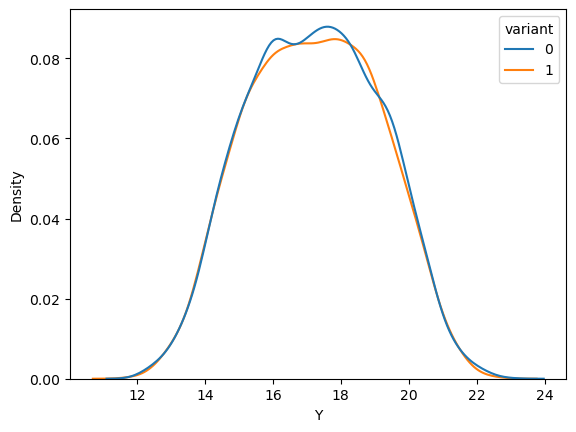

In [77]:
sns.kdeplot(data=cd.data, x=cd.outcomes[0], hue=cd.treatment)

### 1. Propensity model estimation via AutoML


In [85]:
# CausalTune configuration
num_samples = 200
components_time_budget = 800
train_size = 0.7

target = cd.outcomes[0]

In [86]:
ct = AutoCausality(
    num_samples=num_samples,
    components_time_budget=components_time_budget,
    metric="energy_distance",
    verbose=3,
    components_verbose=3,
    train_size=train_size,
)   
ct.fit(data=cd, outcome=target)

[flaml.tune.tune: 05-16 13:43:54] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 05-16 13:43:54] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 13:43:54] {198} INFO - result: {'energy_distance': 0.007011752515238889, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.04208969109980015, 'ate_std': 0.00042308312136897416, 'erupt': 17.227812483605984, 'norm_erupt': 17.22864301778871, 'qini': 4.729713386913961, 'auc': -0.5000773150754506, 'values':       treated          Y         p  policy  norm_policy  weights
0           0  16.443682  0.504143   False         True  2.01671
1           1  19.220052  0.504143   False        False  0.00000
2           1  16.795653  0.504143   False        False  0.00000
3           1  17.168290  0.504143   False        False  0.00000
4           0  17.372071  0.504143   False        False  2.01671
...       ...        ...       ...     ...          ...      ...
6995        0  15.901622  0.504143   False         True  2.01671
6996        0  19.665493  0.504143   False         True  2.01671
6997        1  13.684731  0.504143   False 

Difference in means estimate (naive ATE):

In [80]:
ct.scorer.naive_ate(cd.data[cd.treatment], cd.data[target])[0]

-0.01313951552879189

CausaTune ATE estimate:

In [81]:
ct.effect(ct.test_df).mean()

-0.043028921555375396

### 2. Propensity model estimation with a custom model


### 3. Supplying individual treatment propensities


### 4. Dummy Propensity Model
